<a href="https://colab.research.google.com/github/saifulislamsarfaraz/Statistics-for-Data-Science/blob/main/brain_tumor_with_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color ='brown'>
    

    
### Load and Check Data 

In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


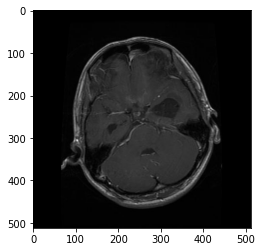

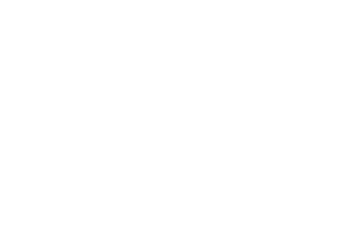

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

DATADIR = r"/content/drive/MyDrive/Colab Notebooks/Brain/Training/"
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(img_array)
        plt.show()
        plt.axis("off")
        break
    break

(-0.5, 149.5, 149.5, -0.5)

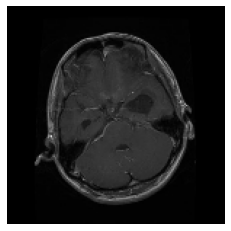

In [3]:
IMG_SIZE = 150
new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))    
plt.imshow(new_array,cmap = "gray")
plt.axis("off")


# Data Visualization 

In [4]:
import plotly.express as px
classes_info = {}
classes = sorted(os.listdir(DATADIR))
for name in classes:
    classes_info[name] = len(os.listdir(DATADIR + f'/{name}'))
print(classes_info)
fig = px.pie(names=classes_info.keys(),values=classes_info.values(),hole=0.05,title='CLasses Info')
fig.update_layout({'title':{"x":0.1}})
fig.show()

{'glioma_tumor': 826, 'meningioma_tumor': 822, 'no_tumor': 403, 'pituitary_tumor': 827}


In [5]:
glimoa_train = os.listdir("/content/drive/MyDrive/Colab Notebooks/Brain/Training/glioma_tumor")
men_train =  os.listdir("/content/drive/MyDrive/Colab Notebooks/Brain/Training/meningioma_tumor")
notumor_train = os.listdir("/content/drive/MyDrive/Colab Notebooks/Brain/Training/no_tumor")
pit_train =  os.listdir("/content/drive/MyDrive/Colab Notebooks/Brain/Training/pituitary_tumor")

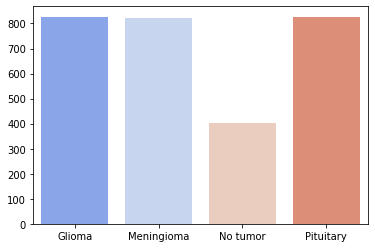

In [6]:
#picture in the  dataset
labels = ["Glioma", "Meningioma", "No tumor", "Pituitary"]
values = [len(glimoa_train), len(men_train), len(notumor_train), len(pit_train)]
sns.barplot(x = labels, y = values, palette="coolwarm")

# MANIPULATING DATA

In [7]:
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()

In [8]:
X = []
y = []
for features,label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE)
print(X.shape)
X = X/255.0  
X = X.reshape(-1,150,150,1)

(2878, 150, 150)


In [9]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
y = to_categorical(y, num_classes = 4)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.3, random_state=42)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (2014, 150, 150, 1)
x_test shape (864, 150, 150, 1)
y_train shape (2014, 4)
y_test shape (864, 4)


# PREDICTION USING CNN

In [11]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop ,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Activation

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=0,
        zoom_range = 0,
        width_shift_range=0,  
        height_shift_range=0,  
        horizontal_flip=True,  
        vertical_flip=False)  

In [13]:
model1 =Sequential()
#4convolution layers and 2 maxpoollayer
model1.add(Conv2D(filters=32,kernel_size=5,input_shape=(150,150,1)))
model1.add(Activation('relu'))

model1.add(Conv2D(filters=32,kernel_size=4,input_shape=(150,150,1)))
model1.add(Activation('relu'))

model1.add(MaxPool2D(pool_size=3))

model1.add(Conv2D(filters=25,kernel_size=3,input_shape=(100,100,1)))
model1.add(Activation('relu'))

model1.add(Conv2D(filters=25,kernel_size=2,input_shape=(50,50,3)))
model1.add(Activation('relu'))

model1.add(MaxPool2D(pool_size=3))
#flatten layer
model1.add(Flatten())
#Deeeper hidden layer
model1.add(Dense(250))
model1.add(Activation('relu'))
#output layer
model1.add(Dense(4))
model1.add(Activation('sigmoid'))
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
epochs= 10


In [14]:
from keras.callbacks import EarlyStopping

early_stop=EarlyStopping(monitor='val_loss',patience=3)

In [15]:
history1 = model1.fit(X_train,Y_train,epochs=15,validation_data=(X_val,Y_val),callbacks=[early_stop])

Epoch 1/15
63/63 [==============================] - 7s 57ms/step - loss: 0.9590 - accuracy: 0.6092 - val_loss: 0.7610 - val_accuracy: 0.6887
Epoch 2/15
63/63 [==============================] - 3s 48ms/step - loss: 0.6644 - accuracy: 0.7269 - val_loss: 0.7220 - val_accuracy: 0.7037
Epoch 3/15
63/63 [==============================] - 3s 43ms/step - loss: 0.4727 - accuracy: 0.8064 - val_loss: 0.4989 - val_accuracy: 0.8032
Epoch 4/15
63/63 [==============================] - 3s 51ms/step - loss: 0.3360 - accuracy: 0.8744 - val_loss: 0.4886 - val_accuracy: 0.8021
Epoch 5/15
63/63 [==============================] - 3s 53ms/step - loss: 0.2501 - accuracy: 0.9176 - val_loss: 0.6087 - val_accuracy: 0.7801
Epoch 6/15
63/63 [==============================] - 3s 53ms/step - loss: 0.1632 - accuracy: 0.9474 - val_loss: 0.6021 - val_accuracy: 0.8252
Epoch 7/15
63/63 [==============================] - 3s 49ms/step - loss: 0.1001 - accuracy: 0.9702 - val_loss: 0.5518 - val_accuracy: 0.8484


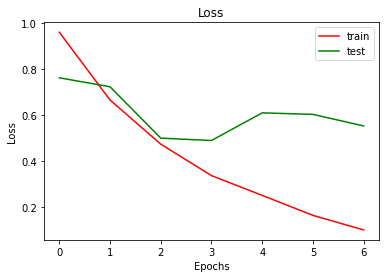

In [16]:
plt.plot(history1.history["loss"],c = "red")
plt.plot(history1.history["val_loss"],c = "green")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

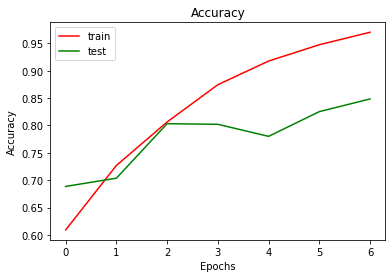

In [17]:
plt.plot(history1.history["accuracy"],c = "red")
plt.plot(history1.history["val_accuracy"],c = "green")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

In [18]:

model2 = Sequential()
#
model2.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (150,150,1)))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.25))
#
model2.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.25))

model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.3))
#
model2.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.3))

#
model2.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.3))

# 
model2.add(Flatten())
model2.add(Dense(1024, activation = "relu"))
model2.add(Dropout(0.5))
model2.add(Dense(4, activation = "softmax"))
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model2.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
epochs = 15  
batch_size = 40



/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [19]:
datagen.fit(X_train)
history2 = model2.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              steps_per_epoch = X_train.shape[0] // batch_size) 

Epoch 1/15


<ipython-input-19-366b0a77e983>:2: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



50/50 [==============================] - 6s 99ms/step - loss: 1.2836 - accuracy: 0.4088 - val_loss: 1.2160 - val_accuracy: 0.4525
Epoch 2/15
50/50 [==============================] - 3s 69ms/step - loss: 0.9895 - accuracy: 0.5729 - val_loss: 0.9635 - val_accuracy: 0.5961
Epoch 3/15
50/50 [==============================] - 4s 72ms/step - loss: 0.8562 - accuracy: 0.6261 - val_loss: 1.0160 - val_accuracy: 0.5359
Epoch 4/15
50/50 [==============================] - 3s 68ms/step - loss: 0.7876 - accuracy: 0.6667 - val_loss: 0.8919 - val_accuracy: 0.5995
Epoch 5/15
50/50 [==============================] - 4s 73ms/step - loss: 0.7053 - accuracy: 0.7067 - val_loss: 0.7079 - val_accuracy: 0.6748
Epoch 6/15
50/50 [==============================] - 4s 76ms/step - loss: 0.6681 - accuracy: 0.7107 - val_loss: 0.6507 - val_accuracy: 0.7002
Epoch 7/15
50/50 [==============================] - 3s 68ms/step - loss: 0.6499 - accuracy: 0.7234 - val_loss: 0.6560 - val_accuracy: 0.7431
Epoch 8/15
50/50 [======

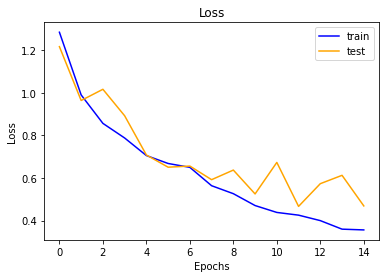

In [20]:
plt.plot(history2.history["loss"],c = "blue")
plt.plot(history2.history["val_loss"],c = "orange")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

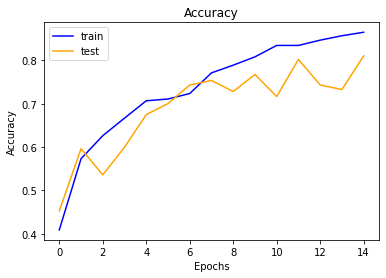

In [21]:
plt.plot(history2.history["accuracy"],c = "blue")
plt.plot(history2.history["val_accuracy"],c = "orange")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

In [22]:

model = Sequential()
# 5 conv. & 5 maxpool
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (150,150,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))
#
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

#
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

# 
model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
epochs = 50  
batch_size = 40
 


In [23]:
datagen.fit(X_train)
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              steps_per_epoch = X_train.shape[0] // batch_size)    

Epoch 1/50


<ipython-input-23-1b6d3c283f0f>:2: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



50/50 [==============================] - 5s 87ms/step - loss: 1.3151 - accuracy: 0.3708 - val_loss: 1.2083 - val_accuracy: 0.4919
Epoch 2/50
50/50 [==============================] - 4s 78ms/step - loss: 1.0137 - accuracy: 0.5517 - val_loss: 0.9710 - val_accuracy: 0.5579
Epoch 3/50
50/50 [==============================] - 4s 79ms/step - loss: 0.8229 - accuracy: 0.6424 - val_loss: 0.8264 - val_accuracy: 0.6123
Epoch 4/50
50/50 [==============================] - 4s 81ms/step - loss: 0.7291 - accuracy: 0.6935 - val_loss: 0.7518 - val_accuracy: 0.6458
Epoch 5/50
50/50 [==============================] - 4s 79ms/step - loss: 0.6865 - accuracy: 0.7153 - val_loss: 0.7813 - val_accuracy: 0.6574
Epoch 6/50
50/50 [==============================] - 4s 79ms/step - loss: 0.6105 - accuracy: 0.7462 - val_loss: 0.7659 - val_accuracy: 0.6771
Epoch 7/50
50/50 [==============================] - 4s 81ms/step - loss: 0.5848 - accuracy: 0.7594 - val_loss: 0.7691 - val_accuracy: 0.6898
Epoch 8/50
50/50 [======

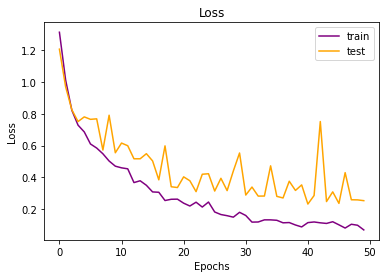

In [24]:
plt.plot(history.history["loss"],c = "purple")
plt.plot(history.history["val_loss"],c = "orange")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

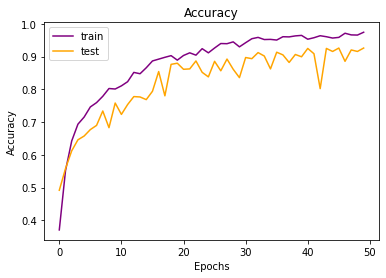

In [25]:
plt.plot(history.history["accuracy"],c = "purple")
plt.plot(history.history["val_accuracy"],c = "orange")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

In [26]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix

In [27]:
import seaborn as sns

27/27 [==============================] - 1s 18ms/step
Confusion Matrix


Text(70.8, 0.5, 'Predicted class')

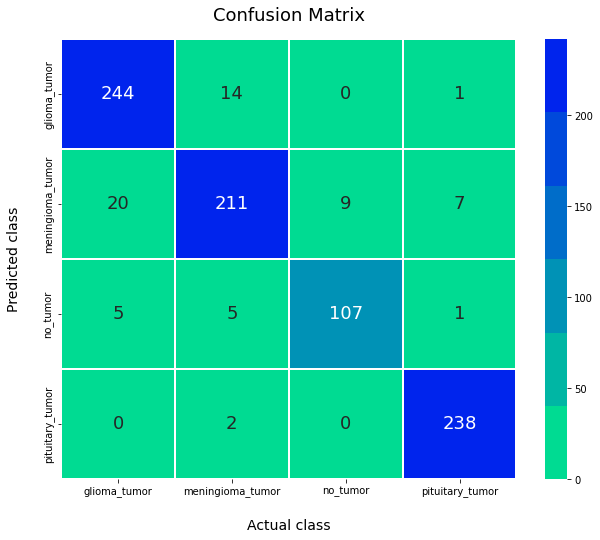

In [28]:
y_test_arg=np.argmax(Y_val,axis=1)
Y_pred = np.argmax(model.predict(X_val),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_arg, Y_pred)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")  #_r inverts the palette
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
#annot_kws: settings about annotations
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)

In [29]:
predict_x=model.predict(X_val) 
classes_x=np.argmax(predict_x,axis=1)
classes_x

27/27 [==============================] - 0s 18ms/step


array([0, 2, 3, 1, 1, 1, 1, 3, 1, 0, 3, 3, 0, 2, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 3, 2, 0, 2, 1, 2, 2, 1, 1, 3, 3, 2, 1, 3, 0, 3, 3, 3, 1, 1, 3,
       1, 2, 2, 0, 3, 1, 2, 3, 2, 3, 3, 0, 0, 3, 1, 1, 0, 3, 1, 1, 0, 0,
       3, 3, 2, 3, 0, 0, 3, 3, 2, 0, 3, 2, 0, 0, 3, 1, 1, 0, 3, 3, 0, 0,
       3, 0, 0, 1, 2, 0, 3, 2, 0, 1, 2, 1, 0, 2, 3, 2, 3, 1, 3, 0, 0, 0,
       0, 3, 0, 2, 1, 1, 3, 3, 1, 0, 3, 0, 0, 1, 3, 2, 3, 0, 2, 1, 3, 1,
       0, 0, 3, 3, 0, 0, 0, 1, 1, 1, 3, 3, 1, 0, 1, 1, 2, 2, 0, 0, 2, 0,
       3, 1, 0, 3, 1, 3, 0, 2, 0, 0, 1, 0, 0, 2, 2, 2, 0, 0, 0, 2, 3, 0,
       0, 3, 1, 1, 1, 3, 1, 1, 3, 0, 3, 0, 3, 0, 0, 1, 3, 1, 3, 3, 0, 0,
       0, 0, 0, 1, 0, 2, 1, 3, 1, 2, 1, 1, 3, 3, 0, 0, 2, 0, 1, 3, 0, 1,
       3, 3, 1, 3, 3, 3, 1, 3, 1, 2, 2, 3, 3, 3, 2, 1, 1, 0, 0, 1, 2, 0,
       3, 0, 1, 1, 0, 1, 2, 0, 0, 1, 1, 0, 0, 1, 2, 1, 1, 3, 2, 3, 3, 0,
       0, 2, 0, 0, 3, 1, 1, 2, 1, 3, 3, 2, 3, 0, 1, 1, 2, 1, 3, 1, 1, 2,
       1, 3, 0, 1, 2, 0, 1, 3, 3, 3, 1, 1, 2, 3, 0,

In [30]:
Y_val2 = np.argmax(Y_val,axis=1)
Y_val2

array([0, 1, 3, 1, 1, 1, 1, 3, 1, 2, 3, 3, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 3, 2, 1, 2, 1, 2, 2, 1, 1, 3, 3, 2, 1, 3, 0, 3, 3, 3, 1, 1, 3,
       1, 2, 2, 0, 3, 1, 2, 3, 1, 3, 3, 1, 0, 3, 1, 1, 0, 3, 1, 0, 0, 0,
       3, 3, 2, 3, 0, 0, 3, 3, 2, 0, 3, 2, 0, 0, 3, 1, 1, 0, 3, 3, 0, 0,
       3, 0, 0, 1, 2, 0, 3, 2, 0, 1, 2, 2, 0, 2, 3, 2, 3, 1, 3, 0, 0, 0,
       1, 3, 0, 2, 1, 1, 3, 3, 1, 0, 3, 0, 0, 1, 3, 2, 3, 1, 2, 1, 3, 2,
       0, 0, 3, 3, 0, 0, 0, 1, 1, 1, 3, 3, 1, 0, 1, 1, 2, 2, 1, 0, 2, 0,
       3, 1, 0, 3, 1, 3, 0, 2, 0, 0, 0, 0, 1, 2, 1, 2, 0, 0, 0, 2, 3, 0,
       0, 3, 1, 1, 1, 3, 1, 1, 3, 0, 3, 1, 3, 0, 1, 1, 3, 1, 3, 1, 0, 0,
       0, 0, 0, 0, 0, 2, 1, 3, 1, 2, 1, 1, 3, 3, 0, 0, 2, 0, 1, 1, 0, 1,
       1, 3, 1, 3, 3, 3, 1, 3, 1, 1, 2, 3, 3, 3, 2, 1, 1, 0, 0, 1, 2, 0,
       3, 0, 1, 1, 0, 1, 2, 0, 0, 1, 1, 0, 0, 1, 2, 1, 1, 3, 2, 3, 3, 1,
       0, 2, 0, 0, 3, 1, 1, 2, 1, 3, 3, 1, 3, 0, 1, 1, 2, 1, 3, 1, 1, 2,
       1, 3, 0, 1, 2, 0, 1, 3, 3, 3, 1, 3, 2, 3, 0,

In [31]:
model.save('brain_tumor_model_2.h5')

In [32]:
from sklearn.metrics import classification_report

In [33]:
print(classification_report(Y_val2,classes_x,target_names=classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.94      0.92       259
meningioma_tumor       0.91      0.85      0.88       247
        no_tumor       0.92      0.91      0.91       118
 pituitary_tumor       0.96      0.99      0.98       240

        accuracy                           0.93       864
       macro avg       0.93      0.92      0.92       864
    weighted avg       0.93      0.93      0.93       864



In [34]:
from keras.models import model_from_json
# serialize model to json
json_model = model.to_json()
#save the model architecture to JSON file
with open('fashionmnist_model.json', 'w') as json_file:
    json_file.write(json_model)
#saving the weights of the model
model.save_weights('FashionMNIST_weights.h5')

# Prediction using Resnet50V2

In [35]:
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.9.2


In [36]:
autotune = tf.data.experimental.AUTOTUNE
batch = 32 * strategy.num_replicas_in_sync
target = [176, 208]
epochs = 100
num_classes=4

In [37]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Brain/Training",
    validation_split=0.2,
    subset="training",
    seed=10,
    image_size=target,
    batch_size=batch,
    color_mode="rgb"
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Brain/Training",
    validation_split=0.2,
    subset="validation",
    seed=10,
    image_size=target,
    batch_size=batch,
    color_mode="rgb"
)

Found 2878 files belonging to 4 classes.
Using 2303 files for training.
Found 2878 files belonging to 4 classes.
Using 575 files for validation.


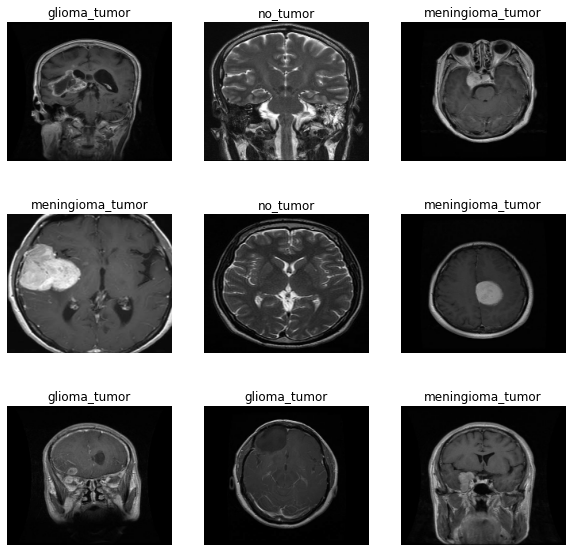

In [38]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #Greyscale
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Feature Engineering

In [39]:
# assigning one hot encoding of labels to train and val dataset
def one_hot_label(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

train_dataset = train_dataset.map(one_hot_label, num_parallel_calls=autotune)
val_dataset = val_dataset.map(one_hot_label, num_parallel_calls=autotune)

In [40]:
# preprocessing stage => rescaling pixel values of images
preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255.)

## Trainig Model

In [41]:
num_images_per_class = []

for label in class_names:
    dir_name = r"/content/drive/MyDrive/Colab Notebooks/Brain/Training/" +  label
    num_images_per_class.append(len([name for name in os.listdir(dir_name)]))
num_images_per_class

[826, 822, 403, 827]

In [42]:
# y_train=list of train labels wrt to given directory format
y_train=[]
for i in range(0, len(num_images_per_class)):
    y_train+=[i]*num_images_per_class[i]

In [43]:
from sklearn.utils.class_weight import compute_class_weight
class_weights=compute_class_weight(class_weight="balanced",classes=[0,1,2,3], y=np.asarray(y_train))
class_weights
# these weights will be used in fit procedure to compute class-weighted loss

array([0.87106538, 0.87530414, 1.7853598 , 0.87001209])

In [44]:
# Create the base model from the pre-trained ResNet50V2 architecture
base_model = tf.keras.applications.ResNet50V2(input_shape=(*target, 3),
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 7, 2048)


In [45]:
# freezing base_model layers
base_model.trainable = False
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 176, 208, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 182, 214, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 88, 104, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 90, 106, 64)  0           ['conv1_conv[0][0]']    

In [46]:
# Global average pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [47]:
# Classification head layer
prediction_layer = tf.keras.layers.Dense(4, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [48]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
# TL model with frozen base
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
import tensorflow_addons as tfa

inputs = tf.keras.Input(shape=(*target, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)        #rescaling
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# using AUC and Weighted-F1Score as primary metrics
model.compile(loss='categorical_crossentropy', optimizer="adadelta", metrics=[AUC(name="auc"),
                                                                            tfa.metrics.F1Score(name="f1", num_classes=4,
                                                                            average="weighted"),
                                                                            CategoricalAccuracy(name="acc")
                                                                            ])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 176, 208, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 6, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_12 (Dropout)        (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 4)                 8196      
                                                             

In [50]:
# Callbacks
import numpy as np
from keras.callbacks import Callback

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("dementia_model.h5",
                                                    save_best_only=True, monitor="val_loss", mode='min')

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True, monitor="val_loss", mode='min')
cb=[checkpoint_cb, early_stopping_cb]
# using 2 callbacks; 
# save best selected model with least val_loss, 
# terminate training run if val_loss doesnt change for 10 epochs

Training runs


In [51]:
# Validation scores before training
model.evaluate(val_dataset)

18/18 [==============================] - 6s 133ms/step - loss: 1.9823 - auc: 0.4076 - f1: 0.1276 - acc: 0.1600


[1.9823215007781982,
 0.40756142139434814,
 0.12755921483039856,
 0.1599999964237213]

In [52]:
# run_1 (training classification head after feature extraction)
history1 = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset, verbose=1, callbacks=cb, use_multiprocessing=True, workers=4, 
                    class_weight={
                                    0: class_weights[0],
                                    1: class_weights[1],
                                    2: class_weights[2],
                                    3: class_weights[3]
                                  })

Epoch 1/50
72/72 [==============================] - 16s 167ms/step - loss: 1.8894 - auc: 0.4366 - f1: 0.1720 - acc: 0.1811 - val_loss: 1.9458 - val_auc: 0.4118 - val_f1: 0.1381 - val_acc: 0.1670
Epoch 2/50
72/72 [==============================] - 16s 206ms/step - loss: 1.8672 - auc: 0.4426 - f1: 0.1917 - acc: 0.1967 - val_loss: 1.9128 - val_auc: 0.4153 - val_f1: 0.1501 - val_acc: 0.1704
Epoch 3/50
72/72 [==============================] - 13s 173ms/step - loss: 1.8434 - auc: 0.4441 - f1: 0.1957 - acc: 0.1980 - val_loss: 1.8823 - val_auc: 0.4196 - val_f1: 0.1515 - val_acc: 0.1687
Epoch 4/50
72/72 [==============================] - 10s 134ms/step - loss: 1.8245 - auc: 0.4526 - f1: 0.2083 - acc: 0.2080 - val_loss: 1.8541 - val_auc: 0.4236 - val_f1: 0.1687 - val_acc: 0.1809
Epoch 5/50
72/72 [==============================] - 10s 134ms/step - loss: 1.8313 - auc: 0.4518 - f1: 0.2055 - acc: 0.2084 - val_loss: 1.8270 - val_auc: 0.4282 - val_f1: 0.1759 - val_acc: 0.1861
Epoch 6/50
72/72 [=======

In [53]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  190


In [54]:
# Fine-tune from this layer onwards
fine_tune_at = 125

# Freezing all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

# 65 layers are set trainable in bottom up manner from classification head
model.compile(loss='categorical_crossentropy', optimizer="adadelta", metrics=[AUC(name="auc"),
                                                                            tfa.metrics.F1Score(name="f1", num_classes=4,
                                                                            average="weighted"),
                                                                            CategoricalAccuracy(name="acc")
                                                                            ])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 176, 208, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 6, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_12 (Dropout)        (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 4)                 8196      
                                                             

In [55]:
# validation scores before training
model.evaluate(val_dataset)

18/18 [==============================] - 3s 83ms/step - loss: 1.3633 - auc: 0.6204 - f1: 0.3327 - acc: 0.3374


[1.3632758855819702,
 0.6204219460487366,
 0.33274877071380615,
 0.33739131689071655]

In [56]:
# run_2 (fine tuning the pretrained layers)
history2 = model.fit(train_dataset,
                    epochs=70,
                    validation_data=val_dataset, verbose=1, callbacks=cb, use_multiprocessing=True, workers=4, 
                    class_weight={
                                    0: class_weights[0],
                                    1: class_weights[1],
                                    2: class_weights[2],
                                    3: class_weights[3]
                                  })

Epoch 1/70
72/72 [==============================] - 19s 182ms/step - loss: 1.2757 - auc: 0.7031 - f1: 0.4475 - acc: 0.4468 - val_loss: 1.0791 - val_auc: 0.7965 - val_f1: 0.5452 - val_acc: 0.5635
Epoch 2/70
72/72 [==============================] - 14s 182ms/step - loss: 1.0325 - auc: 0.8119 - f1: 0.5726 - acc: 0.5753 - val_loss: 0.9078 - val_auc: 0.8668 - val_f1: 0.6533 - val_acc: 0.6713
Epoch 3/70
72/72 [==============================] - 13s 172ms/step - loss: 0.8524 - auc: 0.8733 - f1: 0.6660 - acc: 0.6713 - val_loss: 0.7760 - val_auc: 0.9048 - val_f1: 0.7136 - val_acc: 0.7217
Epoch 4/70
72/72 [==============================] - 13s 176ms/step - loss: 0.7054 - auc: 0.9143 - f1: 0.7260 - acc: 0.7286 - val_loss: 0.6808 - val_auc: 0.9258 - val_f1: 0.7350 - val_acc: 0.7426
Epoch 5/70
72/72 [==============================] - 13s 172ms/step - loss: 0.6219 - auc: 0.9331 - f1: 0.7515 - acc: 0.7542 - val_loss: 0.6123 - val_auc: 0.9387 - val_f1: 0.7696 - val_acc: 0.7739
Epoch 6/70
72/72 [=======

## Evaluating model on test set

In [57]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Brain/Testing/",
    image_size=target,
    batch_size=batch,
    shuffle=False,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=autotune)
test_ds = test_ds.cache().prefetch(buffer_size=autotune)

Found 394 files belonging to 4 classes.


In [58]:
model.evaluate(test_ds)

13/13 [==============================] - 2s 147ms/step - loss: 1.1487 - auc: 0.8975 - f1: 0.7587 - acc: 0.7843


[1.148725986480713, 0.8974528312683105, 0.7586619853973389, 0.7842639684677124]

In [59]:
predictions=model.predict(test_ds)

13/13 [==============================] - 2s 68ms/step


Forming Classification report

In [60]:
# list of number of images belonging to each class in test directory
test_images = []

for label in class_names:
    dir_name = "/content/drive/MyDrive/Colab Notebooks/Brain/Testing/" + label
    test_images.append(len([name for name in os.listdir(dir_name)]))
test_images

[100, 115, 105, 74]

In [61]:
# targets list
targets=[]
for i in range(0, len(test_images)):
    targets+=[i]*test_images[i]
targets=np.asarray(targets)
test_images, class_names, targets

([100, 115, 105, 74],
 ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 

In [62]:
from sklearn.metrics import classification_report
print(classification_report(np.asarray(targets), np.argmax(predictions, axis=1), target_names=class_names))

                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.34      0.50       100
meningioma_tumor       0.71      0.93      0.80       115
        no_tumor       0.74      0.98      0.84       105
 pituitary_tumor       0.96      0.88      0.92        74

        accuracy                           0.78       394
       macro avg       0.84      0.78      0.77       394
    weighted avg       0.82      0.78      0.76       394



# Prediction using Resnet 101V2





In [63]:
base_model_1 = tf.keras.applications.ResNet101V2(input_shape=(*target, 3),
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model_1(image_batch)
print(feature_batch.shape)

(32, 6, 7, 2048)


In [64]:
# freezing base_model layers
base_model_1.trainable = False
base_model_1.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 176, 208, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 182, 214, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 88, 104, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 90, 106, 64)  0           ['conv1_conv[0][0]']   

In [65]:
# Global average pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [66]:
# Classification head layer
prediction_layer = tf.keras.layers.Dense(4, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [67]:
# TL model with frozen base
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
import tensorflow_addons as tfa

inputs = tf.keras.Input(shape=(*target, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)        #rescaling
x = base_model_1(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model1 = tf.keras.Model(inputs, outputs)

# using AUC and Weighted-F1Score as primary metrics
model1.compile(loss='categorical_crossentropy', optimizer="adadelta", metrics=[AUC(name="auc"),
                                                                            tfa.metrics.F1Score(name="f1", num_classes=4,
                                                                            average="weighted"),
                                                                            CategoricalAccuracy(name="acc")
                                                                            ])
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 176, 208, 3)       0         
                                                                 
 resnet101v2 (Functional)    (None, 6, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_13 (Dropout)        (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 4)                 8196      
                                                           

In [68]:
# Callbacks
import numpy as np
from keras.callbacks import Callback

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("dementia_model.h5",
                                                    save_best_only=True, monitor="val_loss", mode='min')

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True, monitor="val_loss", mode='min')
cb=[checkpoint_cb, early_stopping_cb]
# using 2 callbacks; 
# save best selected model with least val_loss, 
# terminate training run if val_loss doesnt change for 10 epochs

In [69]:
# Validation scores before training
model1.evaluate(val_dataset)

18/18 [==============================] - 5s 128ms/step - loss: 1.8446 - auc: 0.5457 - f1: 0.1830 - acc: 0.3026


[1.8445732593536377,
 0.5457401275634766,
 0.18296709656715393,
 0.3026086986064911]

In [70]:
# run_1 (training classification head after feature extraction)
history3 = model1.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset, verbose=1, callbacks=cb, use_multiprocessing=True, workers=4, 
                    class_weight={
                                    0: class_weights[0],
                                    1: class_weights[1],
                                    2: class_weights[2],
                                    3: class_weights[3]
                                  })

Epoch 1/50
72/72 [==============================] - 20s 188ms/step - loss: 1.9019 - auc: 0.5424 - f1: 0.2181 - acc: 0.2905 - val_loss: 1.8033 - val_auc: 0.5477 - val_f1: 0.1846 - val_acc: 0.3009
Epoch 2/50
72/72 [==============================] - 14s 187ms/step - loss: 1.8867 - auc: 0.5435 - f1: 0.2300 - acc: 0.2922 - val_loss: 1.7666 - val_auc: 0.5491 - val_f1: 0.1837 - val_acc: 0.2939
Epoch 3/50
72/72 [==============================] - 14s 185ms/step - loss: 1.8633 - auc: 0.5425 - f1: 0.2266 - acc: 0.2866 - val_loss: 1.7338 - val_auc: 0.5515 - val_f1: 0.1813 - val_acc: 0.2887
Epoch 4/50
72/72 [==============================] - 14s 187ms/step - loss: 1.8408 - auc: 0.5395 - f1: 0.2216 - acc: 0.2779 - val_loss: 1.7044 - val_auc: 0.5534 - val_f1: 0.1928 - val_acc: 0.2939
Epoch 5/50
72/72 [==============================] - 14s 184ms/step - loss: 1.7911 - auc: 0.5469 - f1: 0.2305 - acc: 0.2814 - val_loss: 1.6778 - val_auc: 0.5555 - val_f1: 0.2031 - val_acc: 0.2957
Epoch 6/50
72/72 [=======

In [71]:
base_model_1.trainable = True
print("Number of layers in the base model: ", len(base_model_1.layers))

Number of layers in the base model:  377


In [72]:
# Fine-tune from this layer onwards
fine_tune_at = 125

# Freezing all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

# 65 layers are set trainable in bottom up manner from classification head
model1.compile(loss='categorical_crossentropy', optimizer="adadelta", metrics=[AUC(name="auc"),
                                                                            tfa.metrics.F1Score(name="f1", num_classes=4,
                                                                            average="weighted"),
                                                                            CategoricalAccuracy(name="acc")
                                                                            ])
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 176, 208, 3)       0         
                                                                 
 resnet101v2 (Functional)    (None, 6, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_13 (Dropout)        (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 4)                 8196      
                                                           

In [73]:
# validation scores before training
model1.evaluate(val_dataset)

18/18 [==============================] - 5s 129ms/step - loss: 1.2984 - auc: 0.6695 - f1: 0.3621 - acc: 0.3687


[1.2983975410461426, 0.6694851517677307, 0.362149178981781, 0.3686956465244293]

In [74]:
# run_2 (fine tuning the pretrained layers)
history4 = model1.fit(train_dataset,
                    epochs=70,
                    validation_data=val_dataset, verbose=1, callbacks=cb, use_multiprocessing=True, workers=4, 
                    class_weight={
                                    0: class_weights[0],
                                    1: class_weights[1],
                                    2: class_weights[2],
                                    3: class_weights[3]
                                  })

Epoch 1/70
72/72 [==============================] - 51s 554ms/step - loss: 1.1919 - auc: 0.7357 - f1: 0.4672 - acc: 0.4690 - val_loss: 0.9095 - val_auc: 0.8721 - val_f1: 0.6498 - val_acc: 0.6574
Epoch 2/70
72/72 [==============================] - 39s 527ms/step - loss: 0.8524 - auc: 0.8711 - f1: 0.6476 - acc: 0.6518 - val_loss: 0.6832 - val_auc: 0.9311 - val_f1: 0.7521 - val_acc: 0.7548
Epoch 3/70
72/72 [==============================] - 36s 498ms/step - loss: 0.6389 - auc: 0.9285 - f1: 0.7440 - acc: 0.7464 - val_loss: 0.5472 - val_auc: 0.9547 - val_f1: 0.7847 - val_acc: 0.7878
Epoch 4/70
72/72 [==============================] - 36s 498ms/step - loss: 0.5061 - auc: 0.9547 - f1: 0.8049 - acc: 0.8068 - val_loss: 0.4639 - val_auc: 0.9656 - val_f1: 0.8174 - val_acc: 0.8191
Epoch 5/70
72/72 [==============================] - 36s 495ms/step - loss: 0.4041 - auc: 0.9706 - f1: 0.8495 - acc: 0.8506 - val_loss: 0.4133 - val_auc: 0.9714 - val_f1: 0.8356 - val_acc: 0.8365
Epoch 6/70
72/72 [=======

## Visualizing Model Metrics for Resnet101v2

Run_1: Training classification head after feature extraction from pretrained base

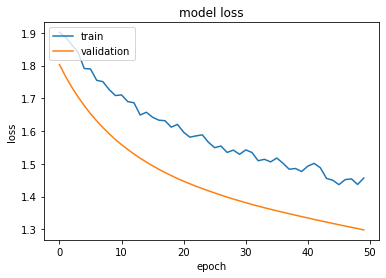

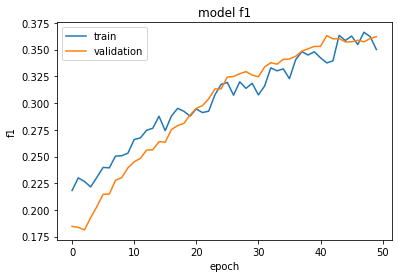

In [75]:
# Plotting train_loss and val_loss wrt epochs
import matplotlib.pyplot as plt
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history3.history['f1'])
plt.plot(history3.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

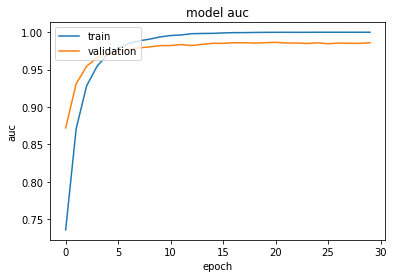

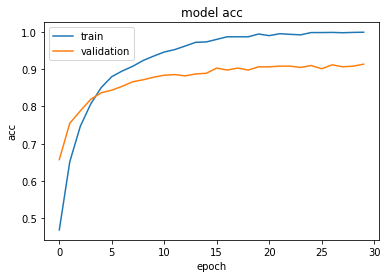

In [76]:
plt.plot(history3.history['auc'])
plt.plot(history3.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Run_2: Fine tuning select layers of pretrained base model

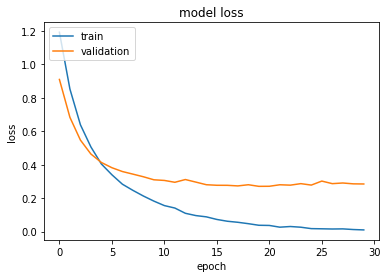

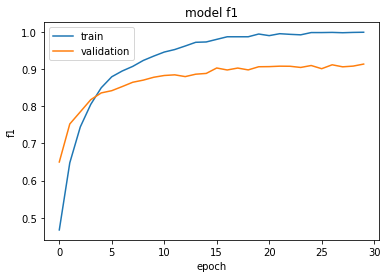

In [77]:
# Plotting train_loss and val_loss wrt epochs
import matplotlib.pyplot as plt
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history4.history['f1'])
plt.plot(history4.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

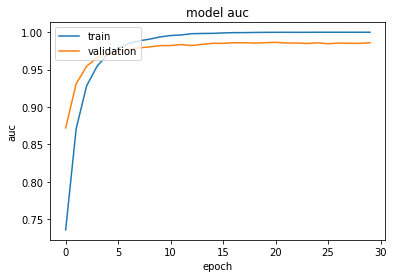

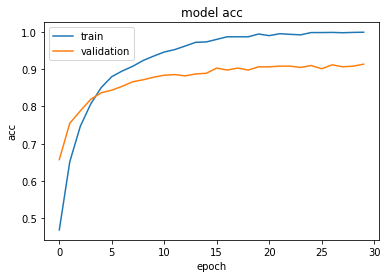

In [78]:
plt.plot(history4.history['auc'])
plt.plot(history4.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [79]:
predictions1=model1.predict(test_ds)

13/13 [==============================] - 3s 125ms/step


In [80]:
from sklearn.metrics import classification_report
print(classification_report(np.asarray(targets), np.argmax(predictions1, axis=1), target_names=class_names))

                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.26      0.41       100
meningioma_tumor       0.64      0.98      0.77       115
        no_tumor       0.80      0.98      0.88       105
 pituitary_tumor       0.95      0.78      0.86        74

        accuracy                           0.76       394
       macro avg       0.84      0.75      0.73       394
    weighted avg       0.82      0.76      0.73       394



# Saving best selected model For Brain Tumor

In [81]:
model.save("dementia_tlmodel.h5")

In [82]:
# generating predictions csv file
import pandas as pd
df=pd.DataFrame(columns=class_names)
for i in range(0, 4):
    df[class_names[i]]=predictions[:,i]

df.to_csv("dementia_tlmodel.csv")